In [1]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [2]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something else than $128\times128$ images.

In [3]:
size = 64
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

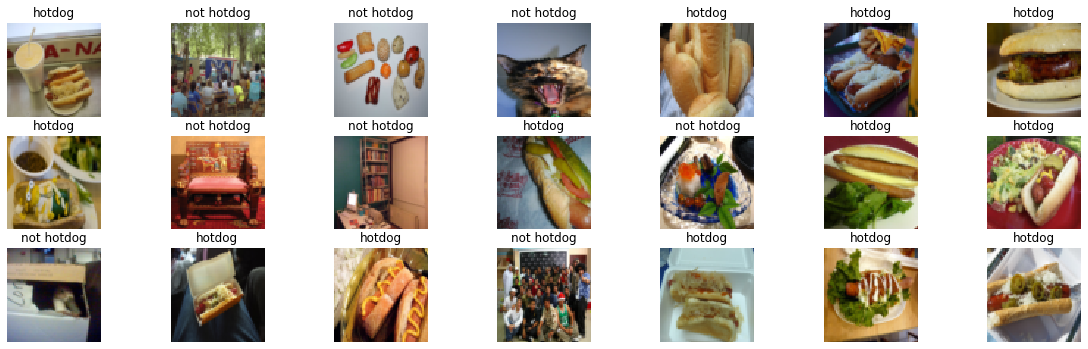

In [4]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [5]:
# setting device
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h2> Neural net

In [34]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(inplace=True),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
#                 nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
#                 nn.ReLU(),
#                 nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
#                 nn.ReLU(),
#                 nn.MaxPool2d(2),
                nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True))

        self.fully_connected = nn.Sequential(
#                 nn.BatchNorm1d(16384),
                nn.Dropout()
                nn.Linear(16384, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 2),
                nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

SyntaxError: invalid syntax (<ipython-input-34-d12b89ee507b>, line 29)

In [35]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [36]:
def train(model, optimizer, loss_function, num_epochs=5):
    train_acc_all, test_acc_all = [], []
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        
        train_correct, test_correct = 0, 0
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            # set the parameter gradients to zero
            optimizer.zero_grad()
            
            output = model(data)
            loss_size = loss_function(output, target)
            loss_size.backward()
            optimizer.step()
            
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().item()
        
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            with torch.no_grad(): # desactivating backpropagation
                output = model(data)
            
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().item()
        
        train_acc = train_correct / len(trainset)
        test_acc = test_correct / len(testset)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
        
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
    
    return train_acc_all, test_acc_all

In [37]:
model = Network()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)

train_acc, test_acc = train(model, optimizer, loss_function, num_epochs=10)

Accuracy train: 60.9%	 test: 59.3%


Accuracy train: 73.7%	 test: 71.4%


Accuracy train: 75.8%	 test: 70.2%


Accuracy train: 74.8%	 test: 70.1%


Accuracy train: 75.9%	 test: 74.1%


Accuracy train: 76.6%	 test: 72.6%


Accuracy train: 78.0%	 test: 72.8%


Accuracy train: 78.1%	 test: 74.6%


Accuracy train: 80.0%	 test: 76.0%


Accuracy train: 80.8%	 test: 75.9%



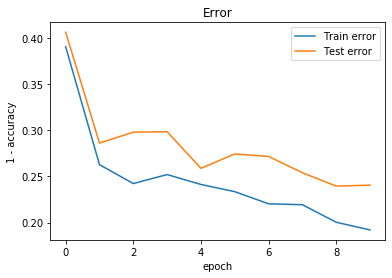

In [38]:
error_train = [1-elt for elt in train_acc]
error_test = [1-elt for elt in test_acc]

plt.figure()
plt.plot(error_train)
plt.plot(error_test)
plt.legend(["Train error", "Test error"]);
plt.title("Error");
plt.xlabel("epoch");
plt.ylabel("1 - accuracy");

In [39]:
model_alex = AlexNet()
model_alex.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alex.parameters(), lr=.0001)

train_acc, test_acc = train(model_alex, optimizer, loss_function, num_epochs=10)

Accuracy train: 51.2%	 test: 48.1%


Accuracy train: 69.3%	 test: 69.0%


Accuracy train: 71.4%	 test: 71.4%


Accuracy train: 74.3%	 test: 71.2%


Accuracy train: 76.9%	 test: 74.1%


Accuracy train: 79.5%	 test: 70.5%


Accuracy train: 82.0%	 test: 75.1%


Accuracy train: 87.7%	 test: 75.8%


Accuracy train: 88.2%	 test: 73.8%


Accuracy train: 93.6%	 test: 73.4%

